# Feature Engineering

---
Feature engineering is one of the keys to unlocking predictive insight through mathematical modeling. 

Based on the data that is available and was cleaned, identify what could be drivers of churn for the client and build those features to later use in the model.

First focus on building on top of the feature that has already investigated: “the difference between off-peak prices in December and January the preceding year”. 

After having a set of features, I train a Random Forest classifier to predict customer churn and evaluate the performance of the model with suitable evaluation metrics. Be rigorous with the approach and give full justification for any decisions made. 

Recall that the hypotheses under consideration is that churn is driven by the customers’ price sensitivities and that it would be possible to predict customers likely to churn using a predictive model.

After that, I investigate the client’s proposed discounting strategy, with the head of the SME division suggesting that offering customers at high propensity to churn a 20% discount might be effective.

---

1. Feature engineering\
1.1 Difference between off-peak prices in December and preceding January\
1.2 Average across period\
1.3 Other features
2. Correlations
3. Modelling\
3.1 Data sampling\
3.2 Model training\
3.3 Evaluation\
3.4 Model understanding\

---


In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
# Load data

In [161]:
df = pd.read_csv('clearn_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [162]:
df.head(3)

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   

   mean_3m_price_peak1_var  mean_3m_price_peak2_var  mean_3m_price_peak3_var  \
0                 0.131756                 0.092638                 0.036909   
1                 0.147600                 0.000000                 0.000000   
2                 0.167798                 0.088409                 0.000000   

   mean_3m_price_peak1_fix  mean_3m_price_peak2_fix  mean_3m_price_peak3_fix  \
0                42.497907                12.218665                 8.145777   
1                44.444710                 0.000000                 0.000000   
2                44.444710                 0.000000                 0.000000   

   mean_3m_price_peak1 mean_3m_price_peak2  mean_3m_price_peak3  churn  
0            42.629663           12.311304             8.182687      1  
1            44.592310            0.000000             0.000000      0  
2            44.612508            0.088409             0.000000      0  

[3 rows x 54 columns]

---

# 1. Feature engineering

## 1.1 Difference between off-peak prices in December and preceding January

Calculate the feature described above as follows:\
1.1.1, select the values of off-peak prices (energy and power) and aggregate by mean.\
1.1.2, separate the values for December and January.\
1.1.3, calculate the difference between December and January.

In [163]:
price_df = pd.read_csv('price_data.csv')

In [164]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')  #the '%y' format: a two-digit year. the '%Y': a four-digit year
price_df.head()

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   
3  038af19179925da21a25619c5a24b745 2015-04-01            0.149626   
4  038af19179925da21a25619c5a24b745 2015-05-01            0.149626   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   
3             0.0                 0.0           44.266931             0.0   
4             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

### 1.1.1 Group off-peak prices by companies and month

In [165]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id','price_date']).agg({'price_off_peak_var':'mean',
                                                                 'price_off_peak_fix':'mean'}).reset_index()
monthly_price_by_id.head()

id price_date  price_off_peak_var  \
0  0002203ffbb812588b632b9e628cc38d 2015-01-01            0.126098   
1  0002203ffbb812588b632b9e628cc38d 2015-02-01            0.126098   
2  0002203ffbb812588b632b9e628cc38d 2015-03-01            0.128067   
3  0002203ffbb812588b632b9e628cc38d 2015-04-01            0.128067   
4  0002203ffbb812588b632b9e628cc38d 2015-05-01            0.128067   

   price_off_peak_fix  
0           40.565969  
1           40.565969  
2           40.728885  
3           40.728885  
4           40.728885

### 1.1.2 Select Dec and Jan prices

In [166]:
# Select jan and december prices (select rows by condition)
jan_prices = monthly_price_by_id[monthly_price_by_id['price_date'] == '2015-01-01'].reset_index()
jan_prices.head()
## another coding option: jan_prices = monthly_price_by_id.groupby().first().reset_index()

index                                id price_date  price_off_peak_var  \
0      0  0002203ffbb812588b632b9e628cc38d 2015-01-01            0.126098   
1     12  0004351ebdd665e6ee664792efc4fd13 2015-01-01            0.148047   
2     24  0010bcc39e42b3c2131ed2ce55246e3c 2015-01-01            0.150837   
3     36  0010ee3855fdea87602a5b7aba8e42de 2015-01-01            0.123086   
4     48  00114d74e963e47177db89bc70108537 2015-01-01            0.149434   

   price_off_peak_fix  
0           40.565969  
1           44.266931  
2           44.444710  
3           40.565969  
4           44.266931

In [167]:
dec_prices = monthly_price_by_id[monthly_price_by_id['price_date']=='2015-12-01'].reset_index()
dec_prices.head()
## another option: dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

index                                id price_date  price_off_peak_var  \
0     11  0002203ffbb812588b632b9e628cc38d 2015-12-01            0.119906   
1     23  0004351ebdd665e6ee664792efc4fd13 2015-12-01            0.143943   
2     35  0010bcc39e42b3c2131ed2ce55246e3c 2015-12-01            0.201280   
3     47  0010ee3855fdea87602a5b7aba8e42de 2015-12-01            0.113068   
4     59  00114d74e963e47177db89bc70108537 2015-12-01            0.145440   

   price_off_peak_fix  
0           40.728885  
1           44.444710  
2           45.944710  
3           40.728885  
4           44.266930

### 1.1.3 Calculate price differences between Dec and Jan

In [168]:
# In order to merge both df (jan&dec) to calculate the difference between prices, 
# first we need to rename the column names of both df,
# then tidy them to merge

dec_prices = dec_prices.rename(columns = {'price_off_peak_var': 'dec_energy',
                                         'price_off_peak_fix':'dec_power'})

In [169]:
jan_prices = jan_prices.rename(columns = {'price_off_peak_var': 'jan_energy',
                                         'price_off_peak_fix':'jan_power'})

In [170]:
# Merge
JanDec = pd.merge(dec_prices,jan_prices,on='id')
JanDec.head()

index_x                                id price_date_x  dec_energy  \
0       11  0002203ffbb812588b632b9e628cc38d   2015-12-01    0.119906   
1       23  0004351ebdd665e6ee664792efc4fd13   2015-12-01    0.143943   
2       35  0010bcc39e42b3c2131ed2ce55246e3c   2015-12-01    0.201280   
3       47  0010ee3855fdea87602a5b7aba8e42de   2015-12-01    0.113068   
4       59  00114d74e963e47177db89bc70108537   2015-12-01    0.145440   

   dec_power  index_y price_date_y  jan_energy  jan_power  
0  40.728885        0   2015-01-01    0.126098  40.565969  
1  44.444710       12   2015-01-01    0.148047  44.266931  
2  45.944710       24   2015-01-01    0.150837  44.444710  
3  40.728885       36   2015-01-01    0.123086  40.565969  
4  44.266930       48   2015-01-01    0.149434  44.266931

In [171]:
# Difference
JanDec['offpeak_diff_Dec_Jan_energy'] = JanDec['dec_energy']-JanDec['jan_energy']
JanDec['offpeak_diff_Dec_Jan_power'] = JanDec['dec_power']-JanDec['jan_power']

In [172]:
# Tidy again
JanDec2 = JanDec[['id','offpeak_diff_Dec_Jan_energy','offpeak_diff_Dec_Jan_power']] # select columns: use [[]]
JanDec2.head()

id  offpeak_diff_Dec_Jan_energy  \
0  0002203ffbb812588b632b9e628cc38d                    -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                    -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                     0.050443   
3  0010ee3855fdea87602a5b7aba8e42de                    -0.010018   
4  00114d74e963e47177db89bc70108537                    -0.003994   

   offpeak_diff_Dec_Jan_power  
0                    0.162916  
1                    0.177779  
2                    1.500000  
3                    0.162916  
4                   -0.000001

### 1.1.4 Merge the new df with previous churn df

In [173]:
df = pd.merge(df, JanDec2, on='id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_peak3_var  mean_3m_price_peak1_fix  mean_3m_price_peak2_fix  \
0                 0.036909                42.497907                12.218665   
1                 0.000000                44.444710                 0.000000   
2                 0.000000                44.444710                 0.000000   
3                 0.000000                44.444710                 0.000000   
4                 0.073719                40.728885                24.437330   

   mean_3m_price_peak3_fix  mean_3m_price_peak1  mean_3m_price_peak2  \
0                 8.145777            42.629663            12.311304   
1                 0.000000            44.592310             0.000000   
2                 0.000000            44.612508             0.088409   
3                 0.000000            44.593296             0.000000   
4                16.291555            40.848791            24.539003   

   mean_3m_price_peak3 churn  offpeak_diff_Dec_Jan_energy  \
0             8.182687     1                     0.020057   
1             0.000000     0                    -0.003767   
2             0.000000     0                    -0.004670   
3             0.000000     0                    -0.004547   
4            16.365274     0                    -0.006192   

   offpeak_diff_Dec_Jan_power  
0                    3.700961  
1                    0.177779  
2                    0.177779  
3                    0.177779  
4                    0.162916  

[5 rows x 56 columns]

## 1.2 Average across period
Here, I create features that look at mean average price differences across three different time periods ("off_peak", "peak", "mid_peak"), instead of looking at differences across the entire year.\
This inter-time-period features would reveal patterns on a micro scale between months, and increase the granularity to the existing feature. 


In [174]:
# Aggregate average prices per period by company ('id')
# working df: price_df
# 首先，按公司“id”分组
# 然后，计算每组中三个时期的平均值

mean_prices_period = price_df.groupby(['id']).agg({
    'price_off_peak_var':'mean',
    'price_peak_var':'mean',
    'price_mid_peak_var':'mean',
    'price_off_peak_fix':'mean',
    'price_peak_fix':'mean',
    'price_mid_peak_fix':'mean'
}).reset_index()
mean_prices_period.head()

id  price_off_peak_var  price_peak_var  \
0  0002203ffbb812588b632b9e628cc38d            0.124338        0.103794   
1  0004351ebdd665e6ee664792efc4fd13            0.146426        0.000000   
2  0010bcc39e42b3c2131ed2ce55246e3c            0.181558        0.000000   
3  0010ee3855fdea87602a5b7aba8e42de            0.118757        0.098292   
4  00114d74e963e47177db89bc70108537            0.147926        0.000000   

   price_mid_peak_var  price_off_peak_fix  price_peak_fix  price_mid_peak_fix  
0            0.073160           40.701732       24.421038           16.280694  
1            0.000000           44.385450        0.000000            0.000000  
2            0.000000           45.319710        0.000000            0.000000  
3            0.069032           40.647427       24.388455           16.258971  
4            0.000000           44.266930        0.000000            0.000000

In [175]:
# Calcualte the mean difference between periods
# Results will be new columns in the df: mean_prices_period

# Energy
mean_prices_period['off_peak_peak_mean_differ_var'] = mean_prices_period['price_off_peak_var']-mean_prices_period['price_peak_var']

mean_prices_period['off_peak_mid_peak_mean_differ_var'] = mean_prices_period['price_off_peak_var']-mean_prices_period['price_mid_peak_var']

mean_prices_period['peak_mid_peak_mean_differ_var'] = mean_prices_period['price_peak_var']-mean_prices_period['price_mid_peak_var']

# Power
mean_prices_period['off_peak_peak_mean_differ_fix'] = mean_prices_period['price_off_peak_fix']-mean_prices_period['price_peak_fix']

mean_prices_period['off_peak_mid_peak_mean_differ_fix'] = mean_prices_period['price_off_peak_fix']-mean_prices_period['price_mid_peak_fix']

mean_prices_period['peak_mid_peak_mean_differ_fix'] = mean_prices_period['price_peak_fix']-mean_prices_period['price_mid_peak_fix']

mean_prices_period.head()

id  price_off_peak_var  price_peak_var  \
0  0002203ffbb812588b632b9e628cc38d            0.124338        0.103794   
1  0004351ebdd665e6ee664792efc4fd13            0.146426        0.000000   
2  0010bcc39e42b3c2131ed2ce55246e3c            0.181558        0.000000   
3  0010ee3855fdea87602a5b7aba8e42de            0.118757        0.098292   
4  00114d74e963e47177db89bc70108537            0.147926        0.000000   

   price_mid_peak_var  price_off_peak_fix  price_peak_fix  price_mid_peak_fix  \
0            0.073160           40.701732       24.421038           16.280694   
1            0.000000           44.385450        0.000000            0.000000   
2            0.000000           45.319710        0.000000            0.000000   
3            0.069032           40.647427       24.388455           16.258971   
4            0.000000           44.266930        0.000000            0.000000   

   off_peak_peak_mean_differ_var  off_peak_mid_peak_mean_differ_var  \
0                       0.020545                           0.051178   
1                       0.146426                           0.146426   
2                       0.181558                           0.181558   
3                       0.020465                           0.049725   
4                       0.147926                           0.147926   

   peak_mid_peak_mean_differ_var  off_peak_peak_mean_differ_fix  \
0                       0.030633                      16.280694   
1                       0.000000                      44.385450   
2                       0.000000                      45.319710   
3                       0.029260                      16.258972   
4                       0.000000                      44.266930   

   off_peak_mid_peak_mean_differ_fix  peak_mid_peak_mean_differ_fix  
0                          24.421038                       8.140345  
1                          44.385450                       0.000000  
2                          45.319710                       0.000000  
3                          24.388456                       8.129484  
4                          44.266930                       0.000000

In [176]:
# Alright, just merge these 6 new results columns (mean differences) in the mean_prices_period with df (churn)

columns = [
    'id',
    'off_peak_peak_mean_differ_var',
    'off_peak_mid_peak_mean_differ_var',
    'peak_mid_peak_mean_differ_var',
    'off_peak_peak_mean_differ_fix',
    'off_peak_mid_peak_mean_differ_fix',
    'peak_mid_peak_mean_differ_fix'
]

df = pd.merge(df,mean_prices_period[columns], on = 'id')
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   mean_3m_price_peak3  churn  offpeak_diff_Dec_Jan_energy  \
0             8.182687      1                     0.020057   
1             0.000000      0                    -0.003767   
2             0.000000      0                    -0.004670   
3             0.000000      0                    -0.004547   
4            16.365274      0                    -0.006192   

   offpeak_diff_Dec_Jan_power  off_peak_peak_mean_differ_var  \
0                    3.700961                       0.024038   
1                    0.177779                       0.142485   
2                    0.177779                       0.082090   
3                    0.177779                       0.151210   
4                    0.162916                       0.020536   

   off_peak_mid_peak_mean_differ_var  peak_mid_peak_mean_differ_var  \
0                           0.058257                       0.034219   
1                           0.149609                       0.007124   
2                           0.170512                       0.088421   
3                           0.151210                       0.000000   
4                           0.051309                       0.030773   

  off_peak_peak_mean_differ_fix  off_peak_mid_peak_mean_differ_fix  \
0                     18.590255                          26.040925   
1                     44.311375                          44.311375   
2                     44.385450                          44.385450   
3                     44.400265                          44.400265   
4                     16.275263                          24.412893   

   peak_mid_peak_mean_differ_fix  
0                       7.450670  
1                       0.000000  
2                       0.000000  
3                       0.000000  
4                       8.137629  

[5 rows x 62 columns]

## 1.3 Other features
1.3.1 Tenure and churn rate\
1.3.2 Transfering dates into months\
1.3.3 Transfering boolean data\
1.3.4 Transfering categorical data\
1.3.5 Transfering numerical data

### 1.3.1 Tenure and churn rate


In [177]:
# Tenure = date of end contract - date of active contract
# Working df: df
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  churn  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...      1   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...      0   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...      0   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...      0   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...      0   

   offpeak_diff_Dec_Jan_energy  offpeak_diff_Dec_Jan_power  \
0                     0.020057                    3.700961   
1                    -0.003767                    0.177779   
2                    -0.004670                    0.177779   
3                    -0.004547                    0.177779   
4                    -0.006192                    0.162916   

   off_peak_peak_mean_differ_var  off_peak_mid_peak_mean_differ_var  \
0                       0.024038                           0.058257   
1                       0.142485                           0.149609   
2                       0.082090                           0.170512   
3                       0.151210                           0.151210   
4                       0.020536                           0.051309   

   peak_mid_peak_mean_differ_var  off_peak_peak_mean_differ_fix  \
0                       0.034219                      18.590255   
1                       0.007124                      44.311375   
2                       0.088421                      44.385450   
3                       0.000000                      44.400265   
4                       0.030773                      16.275263   

  off_peak_mid_peak_mean_differ_fix  peak_mid_peak_mean_differ_fix  tenure  
0                         26.040925                       7.450670       3  
1                         44.311375                       0.000000       7  
2                         44.385450                       0.000000       6  
3                         44.400265                       0.000000       6  
4                         24.412893                       8.137629       6  

[5 rows x 63 columns]

In [178]:
# In order to understand the relationship between churn rate and tenure, 
# need to aggregate mean churn rate by tenure
# 首先，按“tenure”列对 df 进行分组
# 然后，计算每组“churn”列的平均值
# 最后，根据“tenure”列对新的df按升序排列

df.groupby(['tenure']).agg({'churn':'mean'}).sort_values(by='tenure',ascending = True)

churn
tenure          
2       0.129771
3       0.144330
4       0.125791
5       0.085481
6       0.080792
7       0.073451
8       0.048000
9       0.024096
10      0.020000
11      0.063584
12      0.083333
13      0.095238

Here we can see that clients with less than 4 months of tenures are more likely to churn (> 12%) compared to clients with more than 4 months of tenures (<10%).\
The results suggest that perhaps keep clients with over 4 months tenures is more likely to maintain them as long-term customers. 


### 2.3.2 Transfering dates into months

In this section, datetime is used to create other time-related functions to hold some predictive power. New features are as follows: 

1. months_activ = Number of months active until reference date.-the given reference date 2016.1.1\
Since the information in the *"client_data"* shows (contract)date_end from early on 2016.1.28 to 2017.6.13, while the information in the *price_data* shows only 2015 prices\
Therefore, in order to know the "duraction of active", we calculate time difference between the start_date and the reference_date.

2. months_to_end = Number of months left from the given reference date until the end date.
It may reveal the pattern and behavioral about the timing of churn.

3. months_modif_prod = Number of months since last modification until the reference date. 
It may show how engaged a customer is. 

4. months_renewal = Number of months since last renewal until the reference date.
It may show a degree of engagement.


In [179]:
def convert_months(reference_date, df, column):
    time_delta = reference_date - df[column]
    months = (time_delta / np.timedelta64(1,'M')).astype(int)
    return months

In [180]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

  date_activ   date_end date_modif_prod date_renewal  ...  \
0 2013-06-15 2016-06-15      2015-11-01   2015-06-23  ...   
1 2009-08-21 2016-08-30      2009-08-21   2015-08-31  ...   
2 2010-04-16 2016-04-16      2010-04-16   2015-04-17  ...   
3 2010-03-30 2016-03-30      2010-03-30   2015-03-31  ...   
4 2010-01-13 2016-03-07      2010-01-13   2015-03-09  ...   

   off_peak_mid_peak_mean_differ_var  peak_mid_peak_mean_differ_var  \
0                           0.058257                       0.034219   
1                           0.149609                       0.007124   
2                           0.170512                       0.088421   
3                           0.151210                       0.000000   
4                           0.051309                       0.030773   

   off_peak_peak_mean_differ_fix  off_peak_mid_peak_mean_differ_fix  \
0                      18.590255                          26.040925   
1                      44.311375                          44.311375   
2                      44.385450                          44.385450   
3                      44.400265                          44.400265   
4                      16.275263                          24.412893   

   peak_mid_peak_mean_differ_fix  tenure  months_activ months_to_end  \
0                       7.450670       3            30            -5   
1                       0.000000       7            76            -7   
2                       0.000000       6            68            -3   
3                       0.000000       6            69            -2   
4                       8.137629       6            71            -2   

   months_modif_prod  months_renewal  
0                  2               6  
1                 76               4  
2                 68               8  
3                 69               9  
4                 71               9  

[5 rows x 67 columns]

In [181]:
# We no longer need the datetime columns that we used for feature engineering, so we can drop them
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

Unnamed: 0                                id  \
0           0  24011ae4ebbe3035111d65fa7c15bc57   
1           1  d29c2c54acc38ff3c0614d0a653813dd   
2           2  764c75f661154dac3a6c254cd082ea7d   
3           3  bba03439a292a1e166f80264c16191cb   
4           4  149d57cf92fc41cf94415803a877cb4b   

                      channel_sales  cons_12m  cons_gas_12m  cons_last_month  \
0  foosdfpfkusacimwkcsosbicdxkicaua         0         54946                0   
1                           MISSING      4660             0                0   
2  foosdfpfkusacimwkcsosbicdxkicaua       544             0                0   
3  lmkebamcaaclubfxadlmueccxoimlema      1584             0                0   
4                           MISSING      4425             0              526   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   
3             240.04                   0                       0.0   
4             445.75                 526                       0.0   

   forecast_meter_rent_12m  ...  off_peak_mid_peak_mean_differ_var  \
0                     1.78  ...                           0.058257   
1                    16.27  ...                           0.149609   
2                    38.72  ...                           0.170512   
3                    19.83  ...                           0.151210   
4                   131.73  ...                           0.051309   

   peak_mid_peak_mean_differ_var  off_peak_peak_mean_differ_fix  \
0                       0.034219                      18.590255   
1                       0.007124                      44.311375   
2                       0.088421                      44.385450   
3                       0.000000                      44.400265   
4                       0.030773                      16.275263   

  off_peak_mid_peak_mean_differ_fix  peak_mid_peak_mean_differ_fix  tenure  \
0                         26.040925                       7.450670       3   
1                         44.311375                       0.000000       7   
2                         44.385450                       0.000000       6   
3                         44.400265                       0.000000       6   
4                         24.412893                       8.137629       6   

   months_activ  months_to_end  months_modif_prod  months_renewal  
0            30             -5                  2               6  
1            76             -7                 76               4  
2            68             -3                 68               8  
3            69             -2                 69               9  
4            71             -2                 71               9  

[5 rows x 63 columns]

### 1.3.3 Transfering boolean data: has_gas

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14584 entries, 0 to 14583
Data columns (total 63 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         14584 non-null  int64  
 1   id                                 14584 non-null  object 
 2   channel_sales                      14584 non-null  object 
 3   cons_12m                           14584 non-null  int64  
 4   cons_gas_12m                       14584 non-null  int64  
 5   cons_last_month                    14584 non-null  int64  
 6   forecast_cons_12m                  14584 non-null  float64
 7   forecast_cons_year                 14584 non-null  int64  
 8   forecast_discount_energy           14584 non-null  float64
 9   forecast_meter_rent_12m            14584 non-null  float64
 10  forecast_price_energy_off_peak     14584 non-null  float64
 11  forecast_price_energy_peak         14584 non-null  flo

channel_sales: object\
origin_up:     object

If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand.

In [183]:
# Change the category of 'has_gas', change it from categorical data to a binary format (1,0). 
df['has_gas'] = df['has_gas'].replace(['t','f'],[1,0])

In [184]:
df.groupby('has_gas').agg({'churn':'mean'})

churn
has_gas          
0        0.100511
1        0.082042

The result shows that customers who do not have gas are approximately 20% more likely to churn compared to customers who have gas. 

### 1.3.4 Transfering categorical data: channel_sale

In order to run a predictive model, columns with categorical data (channel_sale) should be transformed into numerical.
Here transfer the categorical data into dummy numerical using '.astype()'.

In [185]:
df['channel_sales'] = df['channel_sales'].astype('category')

In [186]:
# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6741
MISSING                             3723
lmkebamcaaclubfxadlmueccxoimlema    1840
usilxuppasemubllopkaafesmlibmsdf    1373
ewpakwlliwisiwduibdlfmalxowmwpci     892
sddiedcslfslkckwlfkdpoeeailfpeds      10
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

The results show that there are 8 categories in the column "channel_sales".

In [187]:
# Use the "pd.get_dummies" function in Pandas for "one-hot encoding" categorical variables. 
## "One-hot encoding" is a technique commonly used in machine learning to represent categorical data in a format suitable for training models.

### "pd.get_dummies" creates a new df with binary columns (1vs.0) for each category (A,B,C). 
### Each binary column corresponds to a unique category (columnA,columnB,columnC), and for each row, 
### only one of these binary columns will be "hot" (1), indicating the presence of that category for that specific row.

df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel') 
# create 8 columns, each presents a category (8 categories in total)
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  months_modif_prod  months_renewal  \
0                        0.114481  ...                  2               6   
1                        0.145711  ...                 76               4   
2                        0.165794  ...                 68               8   
3                        0.146694  ...                 69               9   
4                        0.116900  ...                 71               9   

   channel_MISSING  channel_epumfxlbckeskwekxbiuasklxalciiuu  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_fixdbufsefwooaasfcxdxadsiekoceaa  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_sddiedcslfslkckwlfkdpoeeailfpeds  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

  channel_usilxuppasemubllopkaafesmlibmsdf  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                        0  

[5 rows x 70 columns]

The last three categories occurred only 10, 3, and 2 times respectively.\
They are sddiedcslfslkckwlfkdpoeeailfpeds, epumfxlbckeskwekxbiuasklxalciiuu, fixdbufsefwooaasfcxdxadsiekoceaa.\
However, given there are around 14000 rows, the impact of these three categorises can be almost negligible in the model.\
Therefore, these rows can be removed from the df. 

In [188]:
# Remove three columns
df = df.drop(columns = ['channel_sddiedcslfslkckwlfkdpoeeailfpeds',
                        'channel_epumfxlbckeskwekxbiuasklxalciiuu',
                        'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  tenure  months_activ  months_to_end  \
0                        0.114481  ...       3            30             -5   
1                        0.145711  ...       7            76             -7   
2                        0.165794  ...       6            68             -3   
3                        0.146694  ...       6            69             -2   
4                        0.116900  ...       6            71             -2   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6                0   
1                 76               4                1   
2                 68               8                0   
3                 69               9                0   
4                 71               9                1   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

  channel_usilxuppasemubllopkaafesmlibmsdf  
0                                        0  
1                                        0  
2                                        0  
3                                        0  
4                                        0  

[5 rows x 67 columns]

### 1.3.5 Transfering categorical data: origin_up

In [189]:
df['origin_up'] = df['origin_up'].astype('category')

In [190]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7084
kamkkxfxxuwbdslkwifmmcsiusiuosws    4288
ldkssxwpmemidmecebumciepifcamkci    3145
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similiar to "channel_sale", the last 3 categories show very low frequency: 64, 2 and 1 respectively, and thus can be removed. 


In [191]:
# Use the "pd.get_dummies" function in Pandas for "one-hot encoding" categorical variables. 

df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up') 
# create 6 columns, each presents a category (6 categories in total)
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  \
0                        0.114481  ...   
1                        0.145711  ...   
2                        0.165794  ...   
3                        0.146694  ...   
4                        0.116900  ...   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  origin_up_MISSING  \
0                                         0                  0   
1                                         0                  0   
2                                         0                  0   
3                                         0                  0   
4                                         0                  0   

   origin_up_ewxeelcelemmiwuafmddpobolfuxioce  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  \
0                                           1   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_usapbepcfoloekilkwsdiboslwaxobdp  
0                                           0  
1                                           0  
2                        

In [192]:
df = df.drop(columns=['origin_up_MISSING', 
                      'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 
                      'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57         0         54946   
1           1  d29c2c54acc38ff3c0614d0a653813dd      4660             0   
2           2  764c75f661154dac3a6c254cd082ea7d       544             0   
3           3  bba03439a292a1e166f80264c16191cb      1584             0   
4           4  149d57cf92fc41cf94415803a877cb4b      4425             0   

   cons_last_month  forecast_cons_12m  forecast_cons_year  \
0                0               0.00                   0   
1                0             189.95                   0   
2                0              47.96                   0   
3                0             240.04                   0   
4              526             445.75                 526   

   forecast_discount_energy  forecast_meter_rent_12m  \
0                       0.0                     1.78   
1                       0.0                    16.27   
2                       0.0                    38.72   
3                       0.0                    19.83   
4                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  months_modif_prod  months_renewal  \
0                        0.114481  ...                  2               6   
1                        0.145711  ...                 76               4   
2                        0.165794  ...                 68               8   
3                        0.146694  ...                 69               9   
4                        0.116900  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 69 columns]

### 1.3.6 Transfering numerical data

Since most predictive models typically assume that all variables are normally distributed, it is necessary to consider the skewness. 


In [193]:
# Check distribution
df.describe()

Unnamed: 0      cons_12m  cons_gas_12m  cons_last_month  \
count  14584.000000  1.458400e+04  1.458400e+04     14584.000000   
mean    7301.945968  1.592368e+05  2.804802e+04     16095.545392   
std     4215.540882  5.734890e+05  1.627986e+05     64382.672493   
min        0.000000  0.000000e+00  0.000000e+00         0.000000   
25%     3652.750000  5.680250e+03  0.000000e+00         0.000000   
50%     7301.500000  1.411700e+04  0.000000e+00       793.000000   
75%    10952.250000  4.073750e+04  0.000000e+00      3383.000000   
max    14604.000000  6.207104e+06  4.154590e+06    771203.000000   

       forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
count       14584.000000        14584.000000              14584.000000   
mean         1867.826267         1400.260217                  0.967841   
std          2387.484358         3249.786591                  5.111900   
min             0.000000            0.000000                  0.000000   
25%           495.025000            0.000000                  0.000000   
50%          1112.875000          314.000000                  0.000000   
75%          2399.737500         1745.250000                  0.000000   
max         82902.830000       175375.000000                 30.000000   

       forecast_meter_rent_12m  forecast_price_energy_off_peak  \
count             14584.000000                    14584.000000   
mean                 63.085571                        0.137290   
std                  66.141054                        0.024633   
min                   0.000000                        0.000000   
25%                  16.180000                        0.116340   
50%                  18.805000                        0.143166   
75%                 131.030000                        0.146348   
max                 599.310000                        0.273963   

       forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
count                14584.000000  ...       14584.000000    14584.000000   
mean                     0.050495  ...          35.498217        4.898519   
std                      0.049038  ...          30.251097        3.768027   
min                      0.000000  ...           0.000000        0.000000   
25%                      0.000000  ...           6.000000        2.000000   
50%                      0.084138  ...          31.000000        5.000000   
75%                      0.098837  ...          64.000000        8.000000   
max                      0.195975  ...         151.000000       30.000000   

       channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
count     14584.000000                              14584.000000   
mean          0.255280                                  0.061163   
std           0.436033                                  0.239637   
min           0.000000                                  0.000000   
25%           0.000000                                  0.000000   
50%           0.000000                                  0.000000   
75%           1.000000                                  0.000000   
max           1.000000                                  1.000000   

       channel_foosdfpfkusacimwkcsosbicdxkicaua  \
count                              14584.000000   
mean                                   0.462219   
std                                    0.498588   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%                                    1.000000   
max                                    1.000000   

       channel_lmkebamcaaclubfxadlmueccxoimlema  \
count                              14584.000000   
mean                                   0.126166   
std                                    0.332047   
min                                    0.000000   
25%                                    0.000000   
50%                                    0.000000   
75%       

Here we can see that most of the features are highly skewed. The standard derivation is quite high. 

In [194]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.458400e+04  1.458400e+04     14584.000000       14584.000000   
mean   1.592368e+05  2.804802e+04     16095.545392        1867.826267   
std    5.734890e+05  1.627986e+05     64382.672493        2387.484358   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.680250e+03  0.000000e+00         0.000000         495.025000   
50%    1.411700e+04  0.000000e+00       793.000000        1112.875000   
75%    4.073750e+04  0.000000e+00      3383.000000        2399.737500   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14584.000000              14584.000000             14584.000000   
mean          1400.260217                  0.967841                63.085571   
std           3249.786591                  5.111900                66.141054   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.805000   
75%           1745.250000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14584.000000                14584.000000   
mean                         0.137290                    0.050495   
std                          0.024633                    0.049038   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14584.000000  
mean                     43.130431  
std                       4.488693  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

Note: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

In [195]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [196]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14584.000000  14584.000000     14584.000000       14584.000000   
mean       4.224194      0.778927         2.264855           2.962159   
std        0.884354      1.716950         1.769375           0.683466   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754444      0.000000         0.000000           2.695504   
50%        4.149773      0.000000         2.899821           3.046836   
75%        4.610005      0.000000         3.529430           3.380345   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14584.000000              14584.000000             14584.000000   
mean             1.784555                  0.967841                 1.517374   
std              1.585031                  5.111900                 0.571235   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296775   
75%              3.242106                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14584.000000                14584.000000   
mean                         0.137290                    0.050495   
std                          0.024633                    0.049038   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14584.000000  
mean                     43.130431  
std                       4.488693  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

Now we can see that for the majority of the features, their standard deviation is much lower, which means that features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

C:\Users\18490\AppData\Local\Temp\ipykernel_24224\1385308134.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
C:\Users\18490\AppData\Local\Temp\ipykernel_24224\1385308134.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[df["has_gas"]==1]["cons_gas

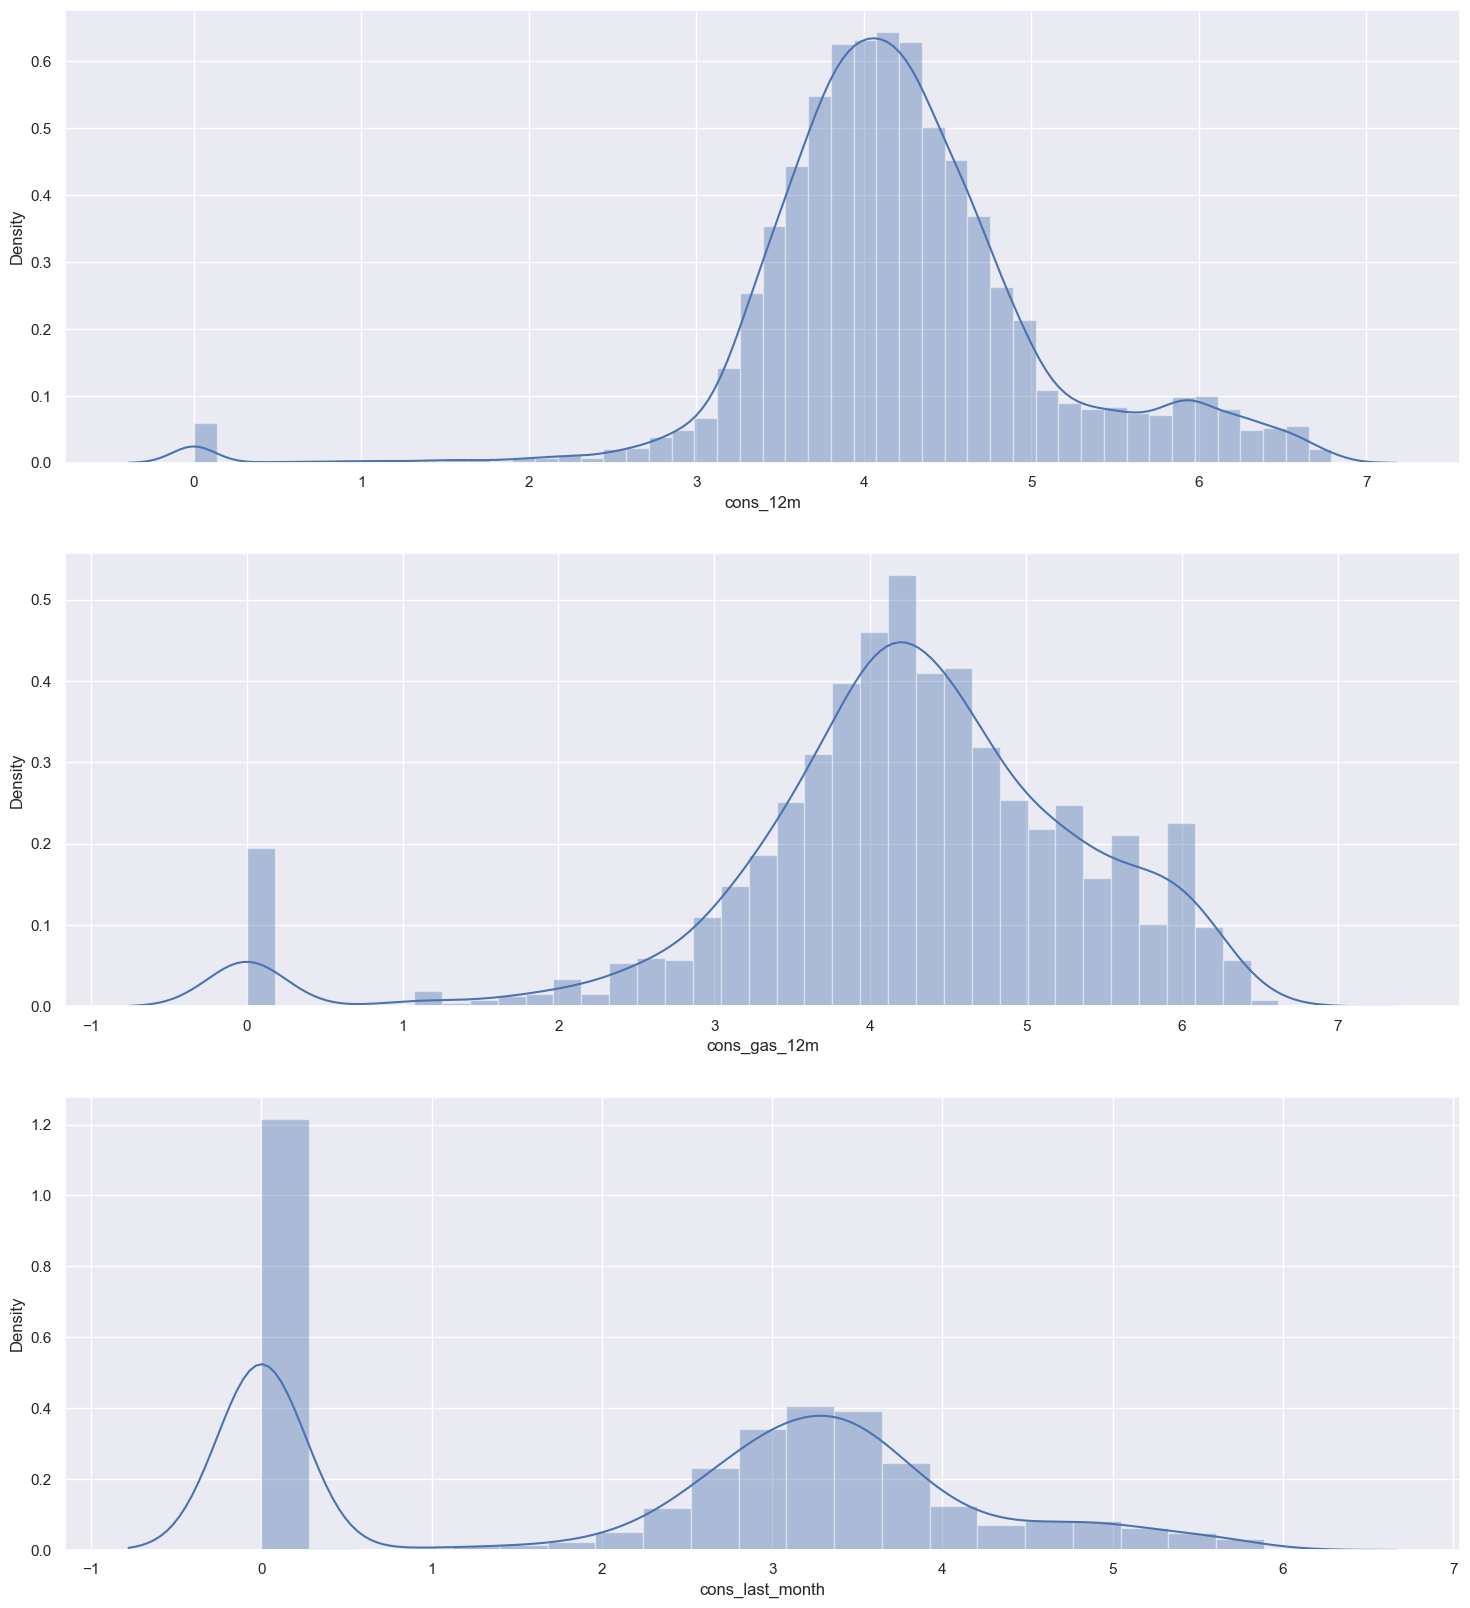

In [197]:
# Lets see three features: cons_12m, has_gas, cons_last_month
# create a grid plot.
## Use "Matplotlib" to create a figure with 3 subplots arranged in a vertical stack. 

# Use Seaborn to create a distribution plot ("sns.distplot") for the 'cons_12m' column. 
## The "dropna()" function is used to remove any missing (NaN) values before plotting.
## ax=axs[0]: This specifies that the plot should be drawn on the first subplot (axs[0]). It can be omitted if you don't have a subplot grid.

fig, axs = plt.subplots(nrows=3, figsize=(18, 20))

sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot(df[df["has_gas"]==1]["cons_gas_12m"].dropna(), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()


# 2. Correlations

Ideally, we want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

In [198]:
# Calculate correlation matrix
correlation = df.corr()

C:\Users\18490\AppData\Local\Temp\ipykernel_24224\2521646261.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


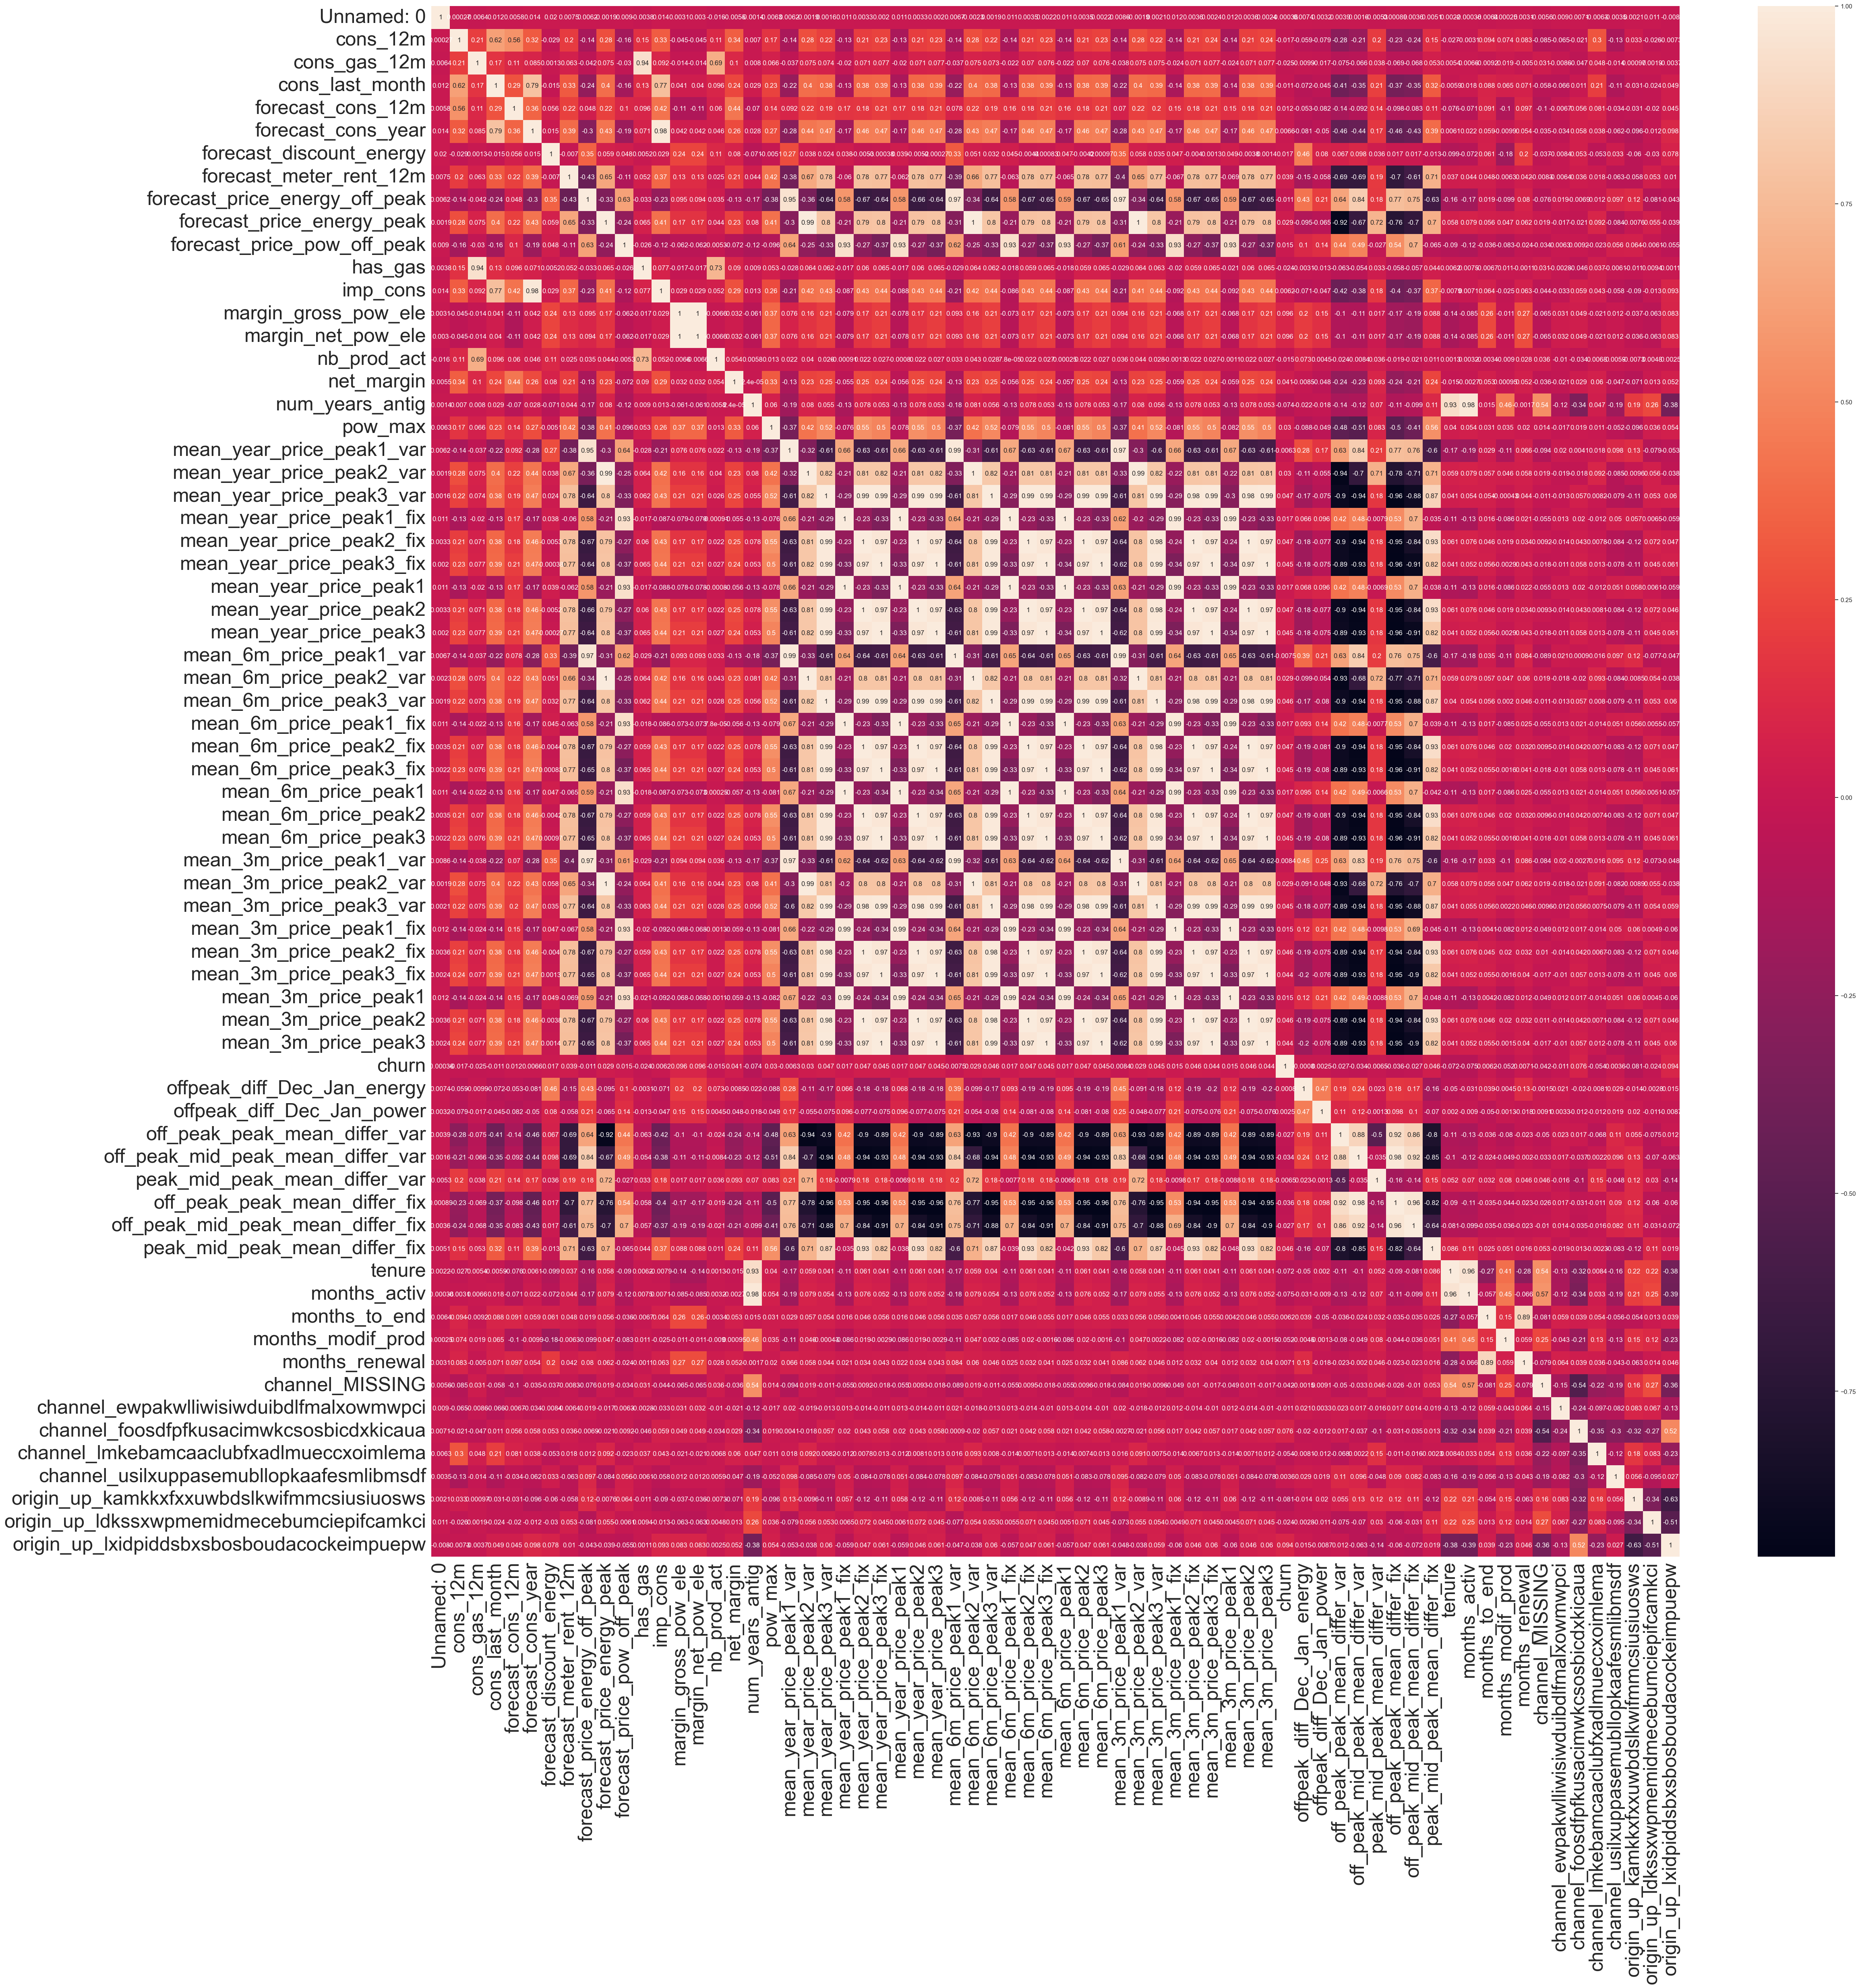

In [199]:
# Plot correlation
plt.figure(figsize = (50,50))
sns.heatmap(correlation,
           xticklabels= correlation.columns.values,
           yticklabels= correlation.columns.values,
           annot=True,           # add annotation
           annot_kws={'size':12} # font size.change as needed
           )

plt.xticks(fontsize=35) # change as needed
plt.yticks(fontsize=35) # change as needed
plt.show()


In [200]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year'])
df.head()

Unnamed: 0                                id  cons_12m  cons_gas_12m  \
0           0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944   
1           1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000   
2           2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000   
3           3  bba03439a292a1e166f80264c16191cb  3.200029      0.000000   
4           4  149d57cf92fc41cf94415803a877cb4b  3.646011      0.000000   

   cons_last_month  forecast_cons_12m  forecast_discount_energy  \
0         0.000000           0.000000                       0.0   
1         0.000000           2.280920                       0.0   
2         0.000000           1.689841                       0.0   
3         0.000000           2.382089                       0.0   
4         2.721811           2.650065                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                 0.444045                        0.114481   
1                 1.237292                        0.145711   
2                 1.599009                        0.165794   
3                 1.318689                        0.146694   
4                 2.122969                        0.116900   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  2               6   
1                    0.000000  ...                 76               4   
2                    0.087899  ...                 68               8   
3                    0.000000  ...                 69               9   
4                    0.100015  ...                 71               9   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   
3                0                                         0   
4                1                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   
3                                         0   
4                                         0   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   
3                                         1   
4                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   
3                                           1   
4                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  
3                                           0  
4                                           0  

[5 rows x 67 columns]

# 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model.\
We need to focus on training a Random Forest classifier.

In [201]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 3.1 Data Sampling

The first thing we need to do is to split the dataset into training and testing samples.\
The reason to do this is to simulate a real life situation by generating predictions for our test sample.\
This would give us the ability to know how well the model we used could generalise to new data.

A typical percentage to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [202]:
# Copy the original df
train = df.copy()

In [203]:
# Specify the target variable and independent variable
# The target variable is the variable that we want to predict: y
# The independent variable is the feature used for prediction: x

y = df['churn']
x = df.drop(columns = ['churn','id'])
print(x.shape)
print(y.shape)

(14584, 65)
(14584,)


In [207]:
x_train,x_test, y_train,y_test = train_test_split(x,y,
                                                    test_size = 0.25,  # 25% test
                                                    random_state = 42) # a convention

Note: the order of small df is crucial when splitting the big df.\
Keep the independent variable `x` the first: `x_train`and`x_test`.\
Followed by the prediction `y`: `y_train` and `y_test`.

If the order is "x_train,x_test, y_train,y_test", there will be a mismatch in the number of samples. 

In [209]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(10938, 65)
(10938,)
(3646, 65)
(3646,)


## 3.2 Model Training

We are using a `Random Forest` classifier. The `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms.

Instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

Here we use `n_estimators` = 1000, which would allow that this random forest consists of 1000 decision trees. 



In [210]:
model = RandomForestClassifier(n_estimators=1000)

model.fit(x_train,y_train)

RandomForestClassifier(n_estimators=1000)

There are many more parameters that can fine-tune within the random forest.\
`n_estimators`:
Definition: Number of trees in the forest.
Tuning: Increasing the number of trees can lead to better generalization performance, but it also increases computational cost.

`max_depth`:
Definition: Maximum depth of the trees.
Tuning: Controls the depth of the individual decision trees. Deeper trees can capture more complex patterns but may lead to overfitting.

`min_samples_split`:
Definition: The minimum number of samples required to split an internal node.
Tuning: A higher value prevents the tree from splitting nodes with a small number of samples, potentially preventing overfitting.

`min_samples_leaf`:
Definition: The minimum number of samples required to be at a leaf node.
Tuning: A higher value makes the tree more robust to noise but can result in underfitting.

`max_features`:
Definition: The maximum number of features to consider for the best split.
Tuning: Controls the randomness of each decision tree. Smaller values can reduce overfitting.

## 3.3 Evaluation

Now, we're going to evaluate how well this trained model is able to predict the values of the test dataset. 

Three metrics are used to evaluate performance：
- Accuracy = the ratio of correctly predicted observations to the total observations.
- Precision = the ability of classifier not to label a negative sample as positive.
- Recall = the ability of classifier to build all the positive samples.  

The reason why need other metrics is because a single accuracy does not cover all situations. For instance, for the prediction of heart failures in a hospital, if the accuracy is as high as 80%, that sounds good, but this means that we predicted 20% wrong. Maybe 20% patients missed out getting treatment to save their lives. 

Moreover, what about the impact of predicting negative cases as positive (people who are not having heart failure beging predicted that they did)? Perhaps a lot of resources get used up on these wrong people. 



In [211]:
predictions = model.predict(x_test)

tn,fp,fn,tp = metrics.confusion_matrix(y_test,predictions).ravel()

- tn: True negatives - the number of instances correctly predicted as the negative class.
- fp: False positives - the number of instances incorrectly predicted as the positive class.
- fn: False negatives - the number of instances incorrectly predicted as the negative class.
- tp: True positives - the number of instances correctly predicted as the positive class.

In [213]:
y_test.value_counts()

0    3300
1     346
Name: churn, dtype: int64

In [216]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {tp}")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test,predictions)}")
print(f"Recall: {metrics.recall_score(y_test,predictions)}")

True positives: 21
False positives: 5
True negatives: 3295
False negatives: 21
Accuracy: 0.9094898518924849
Precision: 0.8076923076923077
Recall: 0.06069364161849711


For the true negatives (tn), we have 3295 out of 3300. This means that out of all negatives (churn = 0), we predicted 3295 as negative (i.e., True negative), which means that we successfully predicted 3295 clients not churn. That is great!

For the false negatives (fn), we predicted 21 client to not churn (churn = 0) when in fact they churned (churn = 1), which is great that the false negatives are as close to 0. 

For the true positives (tp), there are 346 clients that churned in total. However, we are only able to identify 21 out of 346 churned clients, which is poor. 

For the false positives (fp) in which we predicted a client to churn but actually they did not churn. There are only 5 cases, which is great!


For the accuracy rate, which is as high as 0.909, this is misleading. Hense the application of precision and recall is important. 

For the precision score, which is 0.808. This could be improved. 

For the recall rate, which is only 0.061. This means the ability to build all possible samples is very poor. This would be the main concern for improving this model. 

Overall, it is possible to accurately identify clients that do not churn, but we are not able to predict cases where clients churn. Therefore, this situation suggests that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners. 






## 3.4 Model Understanding

Here we look at the importances of feature in the predictive model. In the `Random Forest` case, the feature importance refers to the number of times each feature is used for splitting across all trees. 

In [217]:
feature_importances = pd.DataFrame({
    'features': x_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance',ascending = True).reset_index()

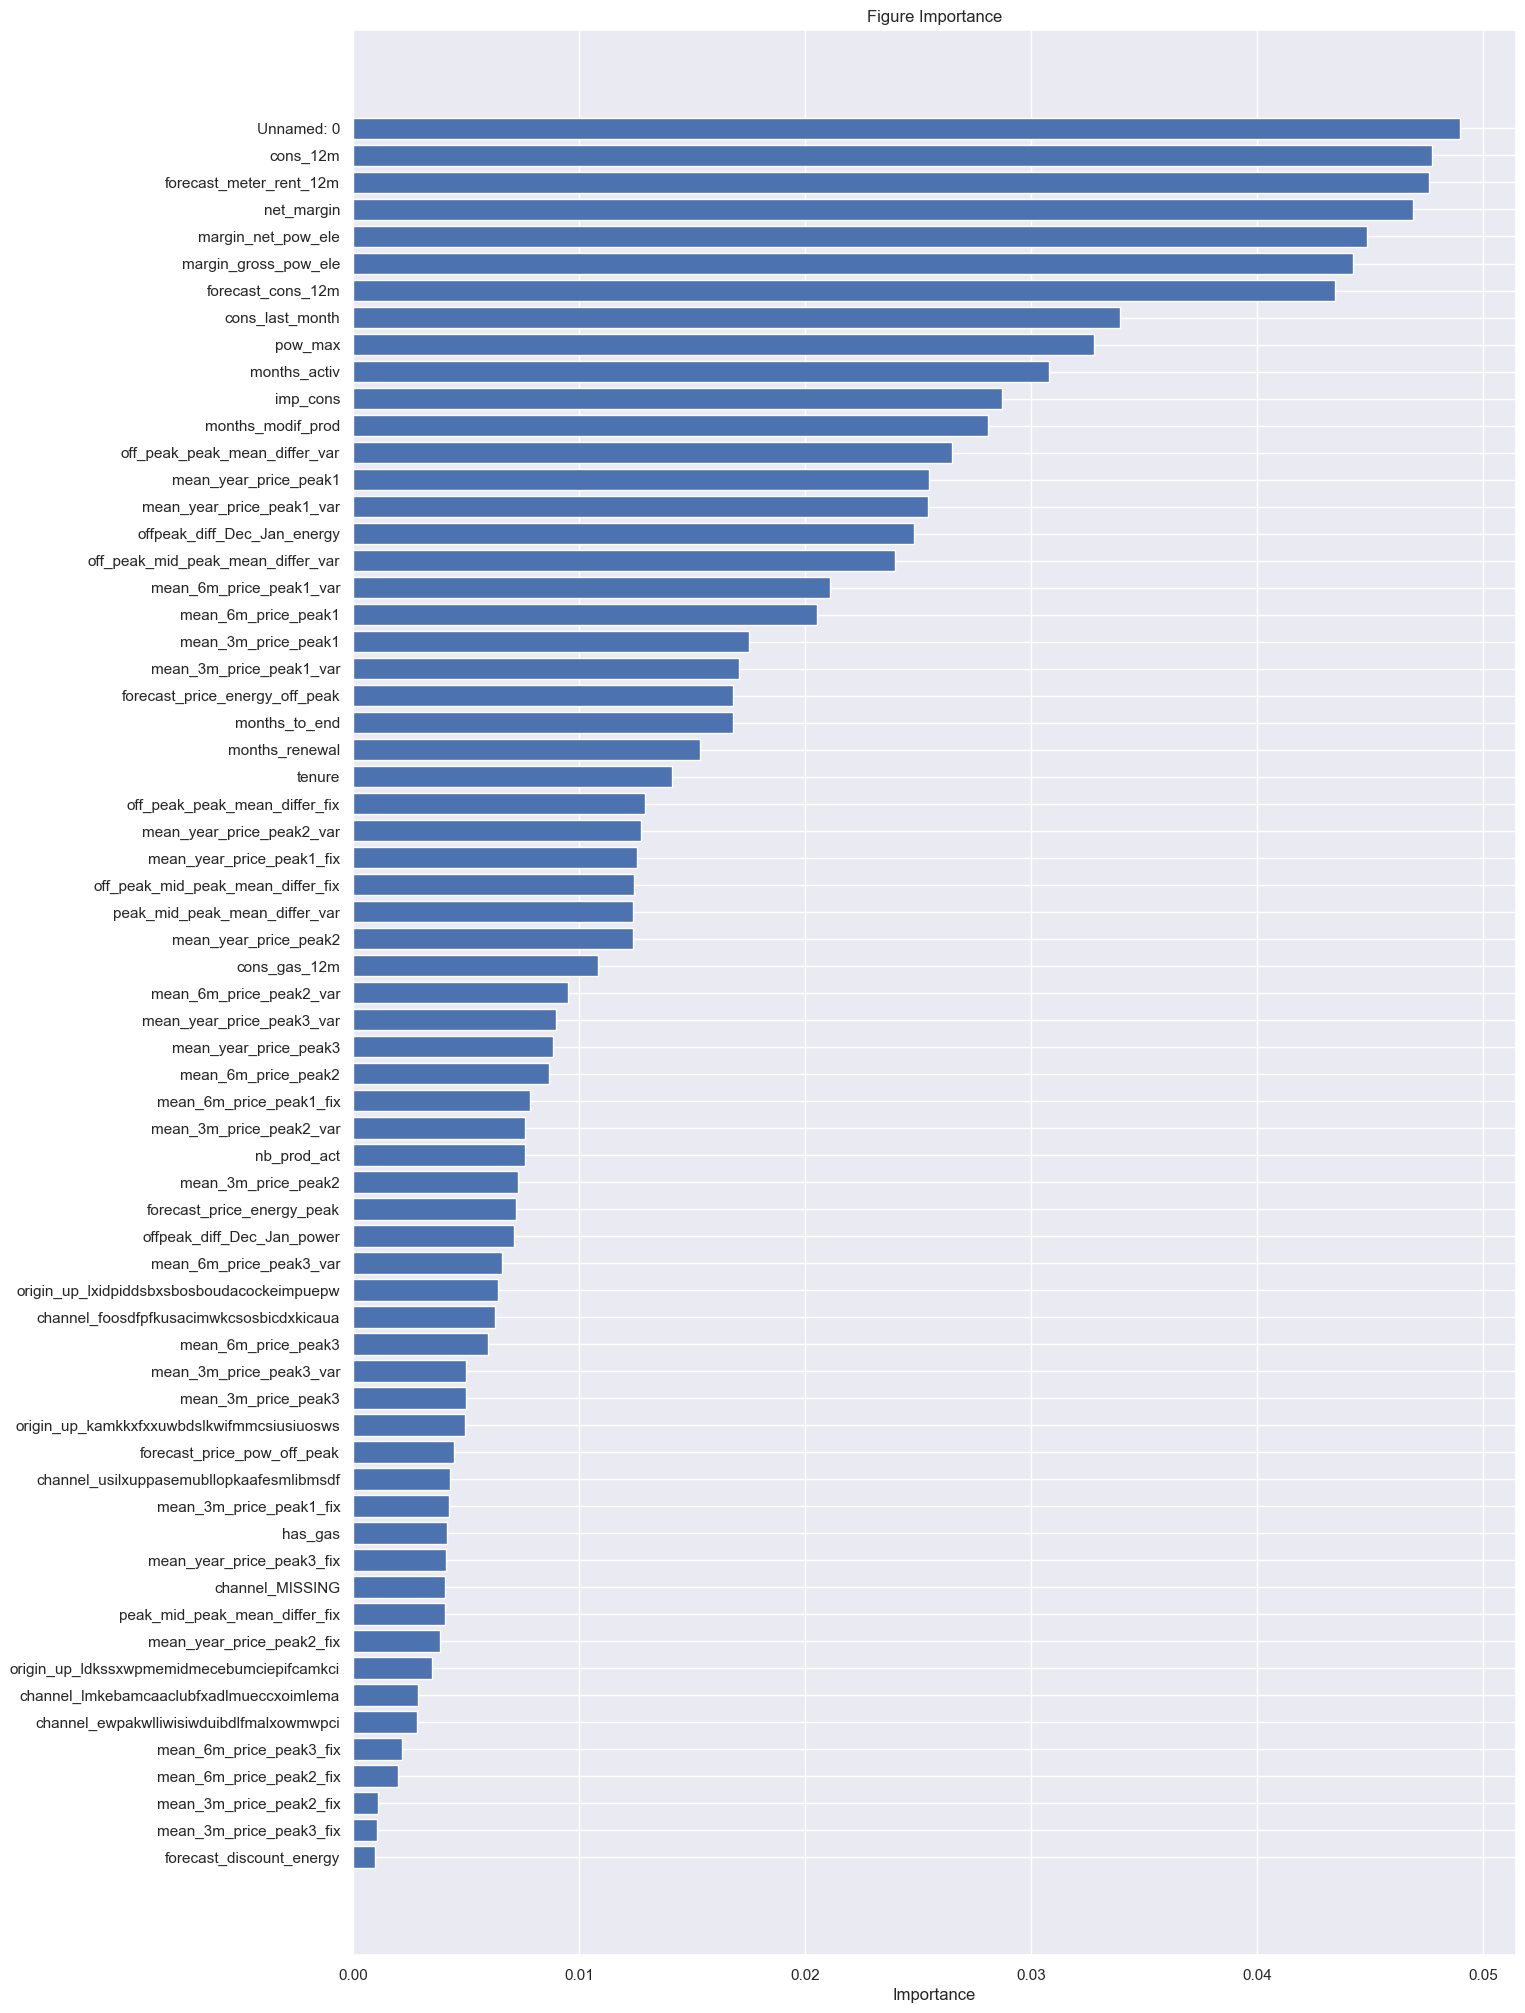

In [218]:
plt.figure(figsize=(15,25))
plt.title('Figure Importance')
plt.barh(range(len(feature_importances)), # y-axis
        feature_importances['importance'],# bar length
        color='b',                        # blue
        align='center')
plt.yticks(range(len(feature_importances)),
          feature_importances['features'])# set the y-axis ticks and labels
plt.xlabel('Importance')
plt.show()

The chart suggests the following points: 
- margin and consuption over 12 months is a top driver for churn. 
- margin on power usbscription also is an influential driver.
- Time seems to be an influential factor, especially the number of months they have been active, their tenure and the number of months since they updated their contract. 
- The price sensitivity features are scattered around but are not the main driver for a customer churning. 

For the original hypothesis: is churn driven by the customers' price sensitivity? 

Our results suggest that the price sensitivity is not a main driver but a weak contributor. 

In [220]:
proba_predictions = model.predict_proba(x_test)
probabilities = proba_predictions[:, 1]

In [221]:
x_test= x_test.reset_index()
x_test.drop(columns='index',inplace=True)

In [222]:
x_test['churn']=predictions.tolist()
x_test['churn_probability']=probabilities.tolist()
x_test.to_csv('out_of_sample_data_with_predictions.csv')